# Opioid Epidemic Exploratory Data Analysis

### Sources:
### 1. OEPS Health04_S
### 2. NSSATS_PUF_2020

In [36]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import seaborn
import pingouin as pg
from pingouin import pairwise_ttests

### Import opioid mortality rate dataset

In [37]:
health04_S_file_path = "../Resources/Health04/Health04_S.csv"
mortality_data = pd.read_csv(health04_S_file_path)
mortality_df = pd.DataFrame(mortality_data)
mortality_df.head(3)

,G_STATEFP,STATEFP,st_abb,st_name,opPrscRt19,prMisuse19,odMortRt14,odMortRt15,odMortRt16,odMortRt17,odMortRt18,odMortRt19,odMortRtAv
0,G01,1,AL,Alabama,39.1,4.55,15.2,15.7,16.2,18.0,16.6,16.3,16.33
1,G02,2,AK,Alaska,85.8,3.99,16.8,16.0,16.8,20.2,14.6,17.8,17.03
2,G04,4,AZ,Arizona,80.9,3.80,18.2,19.0,20.3,22.2,23.8,26.8,21.72


### Create a dataframe with state abbreviation and opioid mortality rate from mortality_data

In [38]:
mort_df = mortality_df.loc[:,['st_abb', 'odMortRtAv']]
mort_df = mort_df.rename(columns={'st_abb' : 'STATE', 'odMortRtAv' : 'odMortRtAv'})
mort_df.head(5)

,STATE,odMortRtAv
0,AL,16.33
1,AK,17.03
2,AZ,21.72
3,AR,14.18
4,CA,12.18


### Import region dataset

In [39]:
region_file_path = "../Resources/Geographic/state_region.csv"
region_data = pd.read_csv(region_file_path)
region_df = pd.DataFrame(region_data).loc[:,['State Code', 'Region', 'Division']].rename(columns={'State Code' : 'STATE', 'Region' : 'REGION', 'Division' : 'DIVISION'})
region_df.head(5)

,STATE,REGION,DIVISION
0,AK,West,Pacific
1,AL,South,East South Central
2,AR,South,West South Central
3,AZ,West,Mountain
4,CA,West,Pacific


### Merge mort and region dfs

In [40]:
mort_region_df = pd.merge(region_df, mort_df, on="STATE", how="inner")
mort_region_df.head(3)

,STATE,REGION,DIVISION,odMortRtAv
0,AK,West,Pacific,17.03
1,AL,South,East South Central,16.33
2,AR,South,West South Central,14.18


### Import treatment facility dataset

In [41]:
nssats_file_path = "../Resources/NSSATS/NSSATS_PUF_2020_CSV.csv"

facility_data = pd.read_csv(nssats_file_path, low_memory=False)
facility_data.head(3)

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,1,AK,2,0,1,1,6,3.0,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,2,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [42]:
facility_df = pd.DataFrame(facility_data)
facility_df.shape

(16066, 262)

### Remove Jurisdictions not included in Health04 dataset

In [43]:
rejected_state_codes = ['PR', 'ZZ']
facility_rejected_state_s = facility_df.STATE.isin(rejected_state_codes)
facility_rejected_state_s

0        False
1        False
2        False
3        False
4        False
         ...  
16061     True
16062     True
16063     True
16064     True
16065     True
Name: STATE, Length: 16066, dtype: bool

In [44]:
facility_df[~facility_rejected_state_s] #with or without loc same output

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,1,AK,2,0,1,1,6,3.0,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,2,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,5,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16051,16052,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
16052,16053,WY,56,1,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,4.0
16053,16054,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
16054,16055,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN


In [45]:
fac_df = facility_df.loc[~facility_df.STATE.isin(rejected_state_codes)]
fac_df

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,1,AK,2,0,1,1,6,3.0,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,2,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,5,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16051,16052,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
16052,16053,WY,56,1,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,4.0
16053,16054,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
16054,16055,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN


In [46]:
fac_df = facility_df.loc[facility_df.STATE != 'PR'].loc[facility_df.STATE != 'ZZ']
fac_df.STATE.nunique()

51

### Merge mortality and facility dfs

In [47]:
df = pd.merge(mort_region_df, fac_df, on = "STATE", how = "inner") 
print(df.shape)
df.head(3)

(15955, 265)


,STATE,REGION,DIVISION,odMortRtAv,CASEID,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,AK,West,Pacific,17.03,1,2,0,1,1,6,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,AK,West,Pacific,17.03,2,2,0,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,AK,West,Pacific,17.03,3,2,1,1,0,2,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


### matplotlib.pyplot.pie(x, explode=None, labels=None, colors=None, autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=None, radius=None, counterclock=True, wedgeprops=None, textprops=None, center=(0, 0), frame=False, rotatelabels=False, *, data=None)[source]


<AxesSubplot:ylabel='CASEID'>

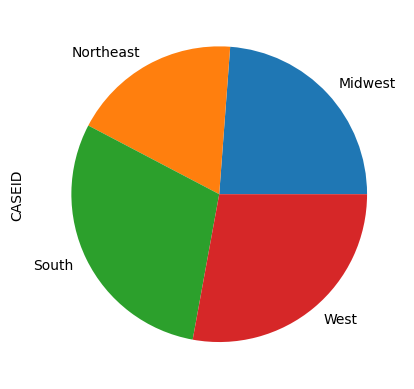

In [48]:
N_groupby = df.groupby(['REGION'])['CASEID'].nunique()
N_groupby
N_groupby.plot.pie()

## OTP: Facility operates an opioid treatment program

In [19]:
df.OTP.value_counts()

0    14208
1     1747
Name: OTP, dtype: int64

### Where are these facilities?

<AxesSubplot:xlabel='REGION'>

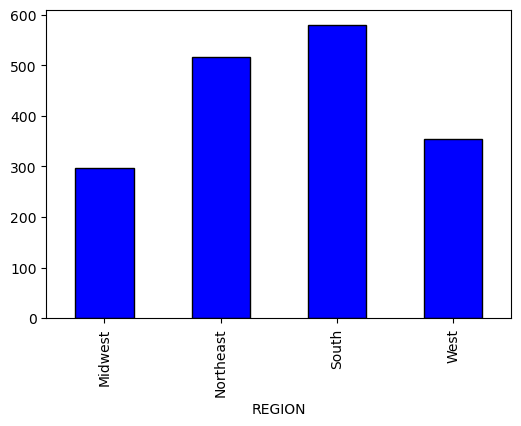

In [35]:
OTP_groupby = df.groupby(['REGION'])['OTP'].sum()
OTP_groupby.plot.bar(color = 'blue', edgecolor = 'black', figsize = [6,4])

In [22]:
percent_OTP_region = 100*(OTP_groupby/N_groupby).round(3)
percent_OTP_region

REGION
Midwest       7.8
Northeast    17.5
South        12.2
West          8.0
dtype: float64

<AxesSubplot:xlabel='REGION'>

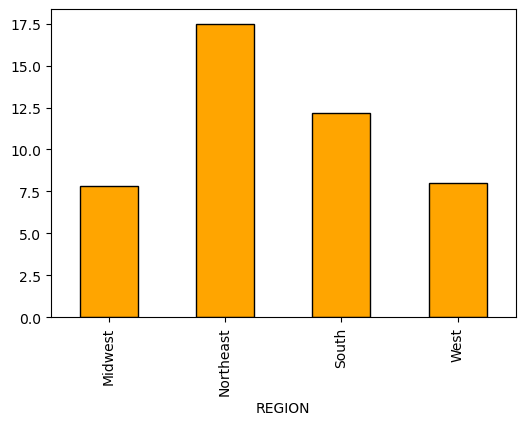

In [34]:
percent_OTP_region.plot.bar(color = 'orange', edgecolor = 'black', figsize = [6,4])

In [25]:
odMortRtAv_groupby = df.groupby(['REGION'])['odMortRtAv'].mean()
odMortRtAv_groupby

REGION
Midwest      19.988679
Northeast    25.105744
South        20.531463
West         16.193836
Name: odMortRtAv, dtype: float64

<AxesSubplot:xlabel='REGION'>

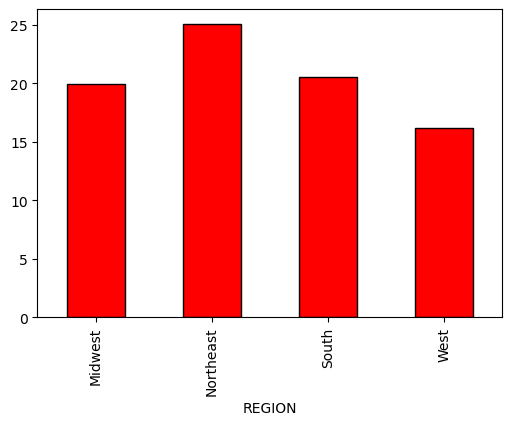

In [33]:
odMortRtAv_groupby.plot.bar(color = 'red', edgecolor = 'black', figsize = [6,4])

In [50]:
percent_OTP_region

REGION
Midwest       7.8
Northeast    17.5
South        12.2
West          8.0
dtype: float64

In [51]:
odMortRtAv_groupby

REGION
Midwest      19.988679
Northeast    25.105744
South        20.531463
West         16.193836
Name: odMortRtAv, dtype: float64

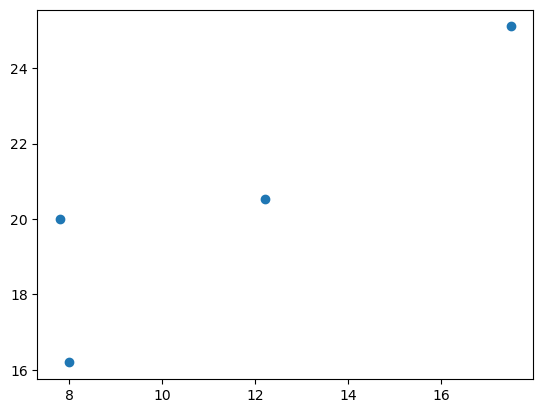

In [53]:
plt.scatter(x=percent_OTP_region, y=odMortRtAv_groupby)

In [54]:
res = sts.pearsonr(percent_OTP_region, odMortRtAv_groupby)
correlation = res[0].round(2)
correlation

0.89

### Treatment Facility Quality (TFQ) - calulcated variable: aggregate measure of assessment, testing, transition, recovery, education, and pharmacotherapies services offereed by each treatment facility surveyed (equally weighted and standardized to scale of 0-10)

In [13]:
a = df.ASSESSMENT #(0-8)
b = df.TESTING #(0-9)
c = df.TRANSITION #(0-4)
d = df.RECOVERY #(0-6)
e = df.EDUCATION #(0-10)
f = df.PHARMACOTHERAPIES #(0-16)

### Standardize on a 0-10 scale using the max of each series 

In [14]:
TFQ_STANDARD_SCALE_MAX = 10

def scale(raw_metric):
    raw_max = raw_metric.max()
    scaled_metric = raw_metric * (TFQ_STANDARD_SCALE_MAX / raw_max)
    return scaled_metric

In [15]:
scale(a)

0         8.75
1         6.25
2         7.50
3        10.00
4         7.50
         ...  
15950     8.75
15951     8.75
15952     8.75
15953     7.50
15954     8.75
Name: ASSESSMENT, Length: 15955, dtype: float64

In [16]:
TFQ_RAW_DIMENSIONS = ['ASSESSMENT', 'TESTING', 'TRANSITION', 'RECOVERY', 'EDUCATION', 'PHARMACOTHERAPIES']

for col in TFQ_RAW_DIMENSIONS:
  df[col + '_SCALED'] = scale(df[col])

In [17]:
TFQ_DIMENSIONS =  [col + '_SCALED' for col in TFQ_RAW_DIMENSIONS] #syntactic sugar

In [18]:
df[TFQ_DIMENSIONS]

,ASSESSMENT_SCALED,TESTING_SCALED,TRANSITION_SCALED,RECOVERY_SCALED,EDUCATION_SCALED,PHARMACOTHERAPIES_SCALED
0,8.75,1.111111,7.5,6.666667,9.0,0.000
1,6.25,2.222222,7.5,10.000000,10.0,9.375
2,7.50,4.444444,7.5,5.000000,8.0,1.875
3,10.00,3.333333,10.0,6.666667,9.0,0.625
4,7.50,10.000000,10.0,6.666667,8.0,8.125
...,...,...,...,...,...,...
15950,8.75,1.111111,5.0,6.666667,7.0,0.625
15951,8.75,4.444444,7.5,8.333333,8.0,4.375
15952,8.75,2.222222,7.5,6.666667,9.0,3.750
15953,7.50,1.111111,7.5,6.666667,9.0,0.000


In [19]:
df[TFQ_DIMENSIONS].mean(axis=1) #check this work after session

0        5.504630
1        7.557870
2        5.719907
3        6.604167
4        8.381944
           ...   
15950    4.858796
15951    6.900463
15952    6.314815
15953    5.296296
15954    5.856481
Length: 15955, dtype: float64

In [20]:
df['TFQ'] = df[TFQ_DIMENSIONS].mean(axis=1)
tfq = df.TFQ
tfq.describe()

count    15955.000000
mean         5.517217
std          1.726054
min          0.208333
25%          4.282407
50%          5.555556
75%          6.761574
max         10.000000
Name: TFQ, dtype: float64

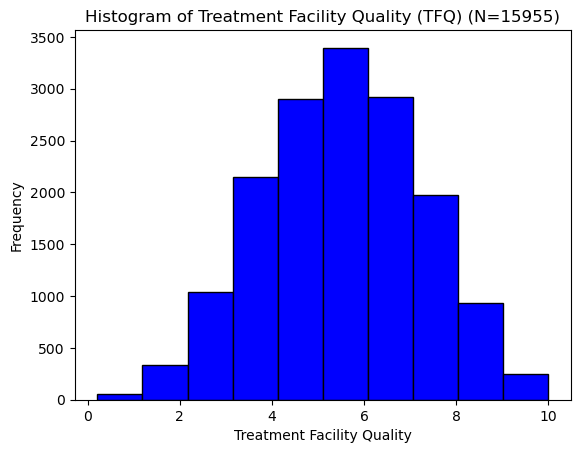

In [21]:
tfq.plot.hist(color = 'blue', edgecolor = 'black')
plt.title(f"Histogram of Treatment Facility Quality (TFQ) (N={len(df)})")
plt.xlabel("Treatment Facility Quality")
plt.show()

### Perform a one-way ANOVA on TFQ here between Regions

<AxesSubplot:title={'center':'TFQ'}, xlabel='REGION'>

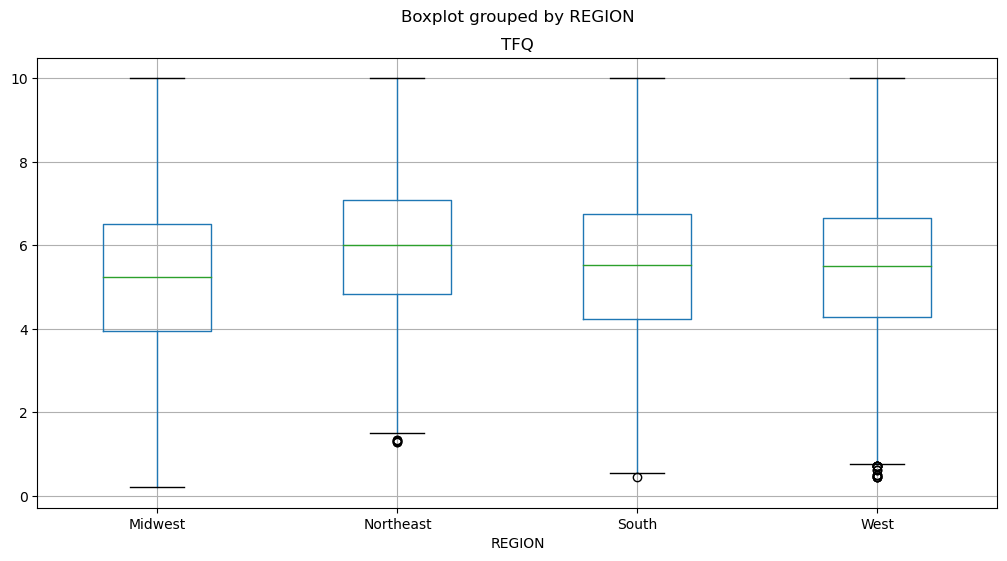

In [24]:
df.boxplot("TFQ", by="REGION", figsize=(12, 6))

In [25]:
WEST = df[df["REGION"] == 'West']['TFQ']
SOUTH = df[df["REGION"] == 'South']['TFQ']
NORTHEAST = df[df["REGION"] == 'Northeast']['TFQ']
MIDWEST = df[df["REGION"] == 'Midwest']['TFQ']

sts.f_oneway(WEST, SOUTH, NORTHEAST, MIDWEST)

F_onewayResult(statistic=87.28851287216956, pvalue=5.0985467232545895e-56)

In [28]:
tfq_pairwise_gameshowell = pg.pairwise_gameshowell(data=df, dv="TFQ", between="REGION").sort_values(['pval'], ascending = True).set_index('A')
tfq_pairwise_gameshowell

,B,mean(A),mean(B),diff,se,T,df,pval,hedges
A,,,,,,,,,
Midwest,Northeast,5.260597,5.932830,-0.672233,0.040638,-16.542106,6531.901702,0.000000e+00,-0.402218
Northeast,West,5.932830,5.479886,0.452944,0.039596,11.439043,6708.294141,0.000000e+00,0.266510
Northeast,South,5.932830,5.499285,0.433545,0.038681,11.208201,6595.687012,1.259770e-12,0.258181
Midwest,South,5.260597,5.499285,-0.238688,0.037487,-6.367182,8147.273715,1.218437e-09,-0.138498
Midwest,West,5.260597,5.479886,-0.219289,0.038431,-5.706068,8096.429189,7.171459e-08,-0.125826
South,West,5.499285,5.479886,0.019399,0.036356,0.533580,9131.380687,9.508992e-01,0.011137


In [29]:
tfq_pairwise_gameshowell.to_csv("Results/TFQ_pairwise_ttest_results.csv")

In [59]:
omr = df['odMortRtAv']
omr.describe()

count    15955.000000
mean        20.039247
std          6.985984
min          9.750000
25%         14.880000
50%         18.570000
75%         23.070000
max         48.520000
Name: odMortRtAv, dtype: float64

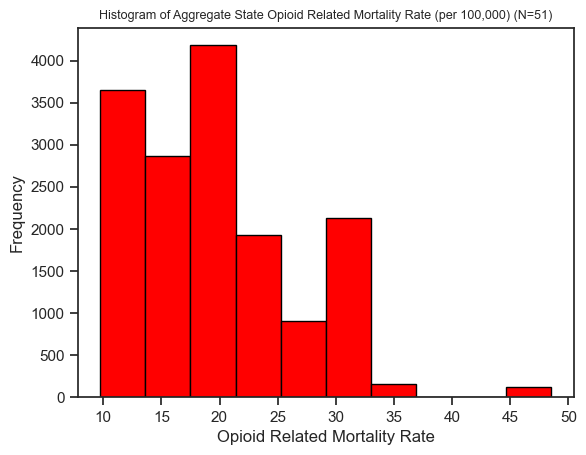

In [60]:
omr.plot.hist(color = 'red', edgecolor = 'black')
plt.title(f"Histogram of Aggregate State Opioid Related Mortality Rate (per 100,000) (N={len(mort_df)})", size = 9)
plt.xlabel("Opioid Related Mortality Rate")
plt.show()

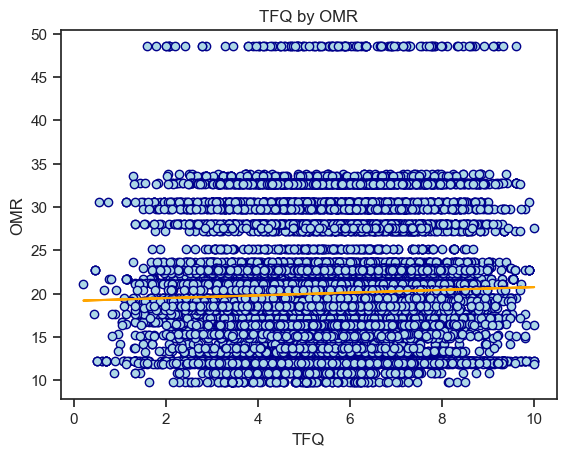

In [61]:
a, b = np.polyfit(tfq, omr, 1)

plt.scatter(tfq, omr, color = 'lightblue', edgecolor = 'darkblue')
plt.plot(tfq, a*tfq+b, color = 'orange')
plt.title("TFQ by OMR")
plt.xlabel("TFQ")
plt.ylabel("OMR")
plt.show()

In [62]:
# Percent of average OMR change for every 1 TFQ point
round(a/omr.mean()*100,2)

0.79

### Aggregate by State

In [63]:
tfq_groupby = df.groupby('STATE')['TFQ'].mean()
tfq_groupby_df = pd.DataFrame(tfq_groupby)
df2 = tfq_groupby_df.reset_index()
df2.head(2)

,STATE,TFQ
0,AK,5.700838
1,AL,5.414606


In [65]:
df3 = pd.merge(mort_region_df, df2, on = "STATE", how = "inner")
print(df3.shape)
df3.head()

(51, 5)


,STATE,REGION,DIVISION,odMortRtAv,TFQ
0,AK,West,Pacific,17.03,5.700838
1,AL,South,East South Central,16.33,5.414606
2,AR,South,West South Central,14.18,5.092457
3,AZ,West,Mountain,21.72,5.612644
4,CA,West,Pacific,12.18,5.683144


### Plot TFQ by OMR adding a line of best fit

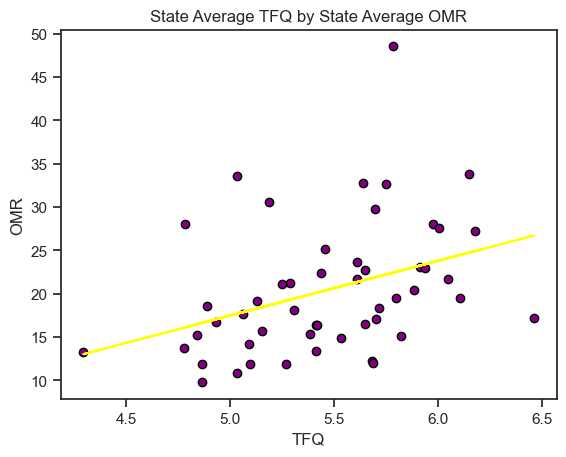

In [68]:
x = df3.TFQ
y = df3.odMortRtAv

a, b = np.polyfit(x, y, 1)

res = sts.pearsonr(x, y)
correlation = res[0].round(2)

plt.scatter(x, y, color = 'purple', edgecolor = 'black')
plt.plot(x, a*x+b, color = 'yellow')
plt.title("State Average TFQ by State Average OMR")
plt.xlabel("TFQ")
plt.ylabel("OMR")
plt.show()

### Plot TFQ by OMR adding a line of best fit

In [69]:
x = df3.TFQ
y = df3.odMortRtAv
res = sts.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.137493


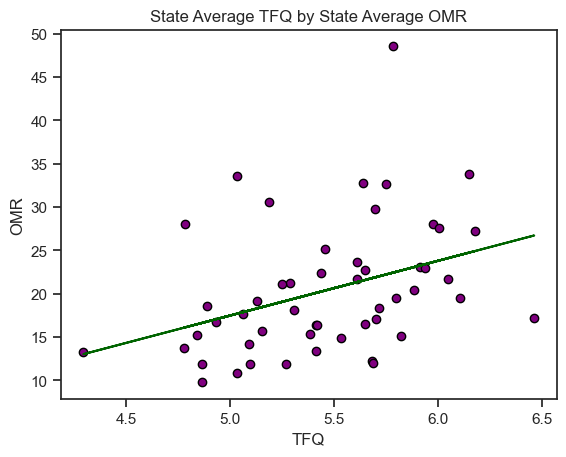

In [70]:
plt.scatter(x, y, color = 'purple', edgecolor = 'black', label='Original Data')
plt.plot(x, res.intercept + res.slope*x, 'darkgreen', label='Fitted Line')
plt.title("State Average TFQ by State Average OMR")
plt.xlabel("TFQ")
plt.ylabel("OMR")
plt.show()

### Note: Block out states by region of country to control for regional factors

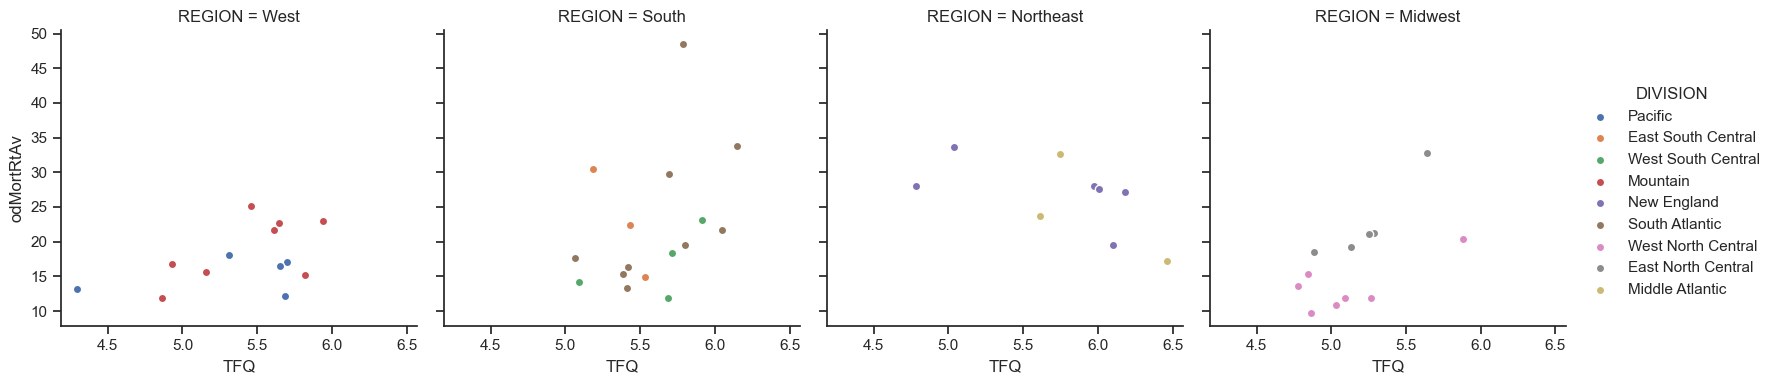

In [71]:
res = sts.linregress(df3.TFQ, df3.odMortRtAv)
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(df3, col ="REGION",  hue ="DIVISION", height = 4)
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "TFQ", "odMortRtAv", edgecolor ="w").add_legend()
# show the object
plt.show()

In [73]:
regions = list(df3.REGION.unique())
statistics = {}
for region in regions:
    subset = df3.loc[df3['REGION'] == region]
    result = sts.linregress(subset.TFQ, subset.odMortRtAv)
    statistics[region] = result
statistics

{'West': LinregressResult(slope=4.2943662673512355, intercept=-5.521522284413507, rvalue=0.4636697740604558, pvalue=0.11051035310700184, stderr=2.474182000638377, intercept_stderr=13.381049068057122),
 'South': LinregressResult(slope=11.709494880223083, intercept=-43.633413936882896, rvalue=0.3932564953265708, pvalue=0.11837471659179431, stderr=7.068621594328721, intercept_stderr=39.4508562684062),
 'Northeast': LinregressResult(slope=-5.984649595849862, intercept=60.894294475971165, rvalue=-0.5986104806655508, pvalue=0.08855341702141366, stderr=3.0269115684189085, intercept_stderr=17.52583653060862),
 'Midwest': LinregressResult(slope=12.233344955095541, intercept=-45.960689658658055, rvalue=0.630452774378319, pvalue=0.027967085675054175, stderr=4.7630127823804695, intercept_stderr=24.639197539857147)}

# Notes from Turoting Session:
### 1. ANOVA on TFQ
### 2. ANOVA on Mortality Rate
### 3. Machine Learning: Regression on Individual Paramters --> Feature Importance
### 4. Multi-Variate Linear Regression --> TFQ might crumble because some parameters don't matter
### 5. Feature Importance! (Direction worth researching) --> which dimensions really matter 

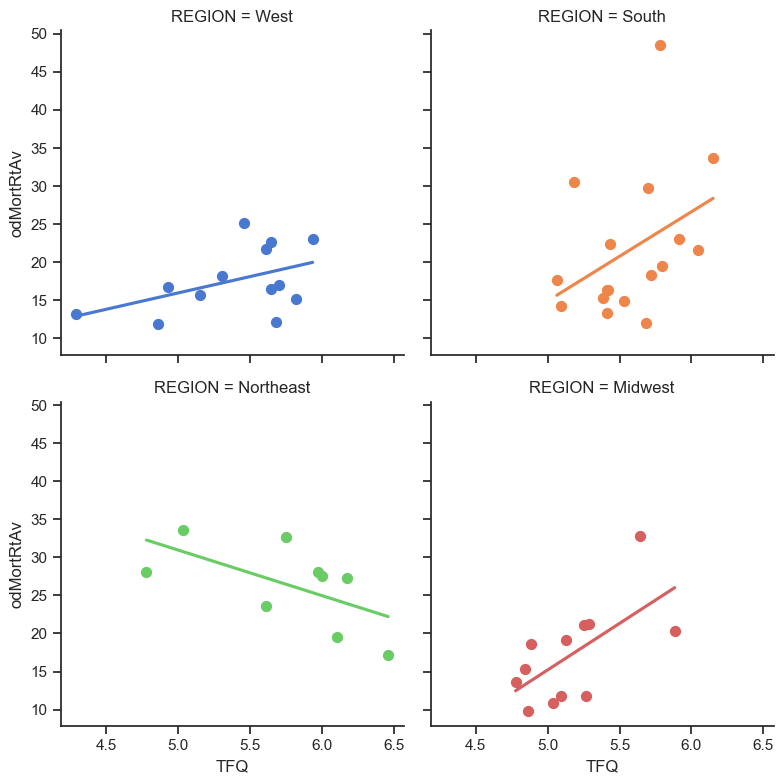

In [74]:
seaborn.set_theme(style="ticks")
seaborn.lmplot(
    data=df3, x="TFQ", y="odMortRtAv", col="REGION", hue="REGION",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
)

# Binning

In [ ]:
tfq_groupby.plot.hist(figsize=[5,5],color='purple',edgecolor='black')
plt.show()

In [53]:
tfq_bins = [0, 22, 29, 35.5, 52]
tfq_bin_names = ["D", "C", "B", "A"]

df['TFQ_BIN'] = pd.cut(df['TFQ'], tfq_bins, labels=tfq_bin_names, include_lowest=True)
df.TFQ_BIN.value_counts()

C    4179
B    4063
D    3976
A    3737
Name: TFQ_BIN, dtype: int64

<AxesSubplot:ylabel='Frequency'>

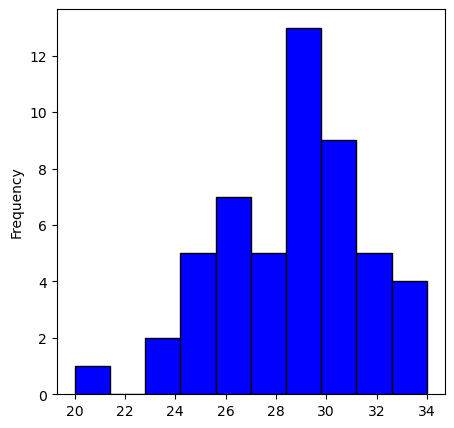

In [50]:
tfq_groupby = df.groupby('STATE')['TFQ'].median()
tfq_groupby.plot.hist(figsize=[5,5],color='blue',edgecolor='black')